# Vienna OSMnx data

## Imports

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import osmnx as ox
import os
import re
import pickle
import copy
import networkx as nx
from shapely.geometry import LineString

import sys
sys.path.append('../src/data')
from download_pois_networks import download_POIs
from download_pois_networks import download_street_network, networks_to_gdf, analyze_street_network

## Retrieve data

In [2]:
# Download POIs
tags={'shop':['supermarket'],'leisure':['park']}
boundary, pois = download_POIs(place_name="Vienna, Austria", tags=tags)

Total POIs: 2156
Found 1046 shop-supermarket
Found 1110 leisure-park


In [3]:
# Download networks
boundary, networks = download_street_network("Vienna, Austria", network_types=['drive', 'bike', 'walk'])

Drive network: 16056 nodes, 35742 edges
Bike network: 50833 nodes, 125064 edges
Walk network: 126905 nodes, 367144 edges


In [4]:
pois.head()

addr:city addr:country addr:housenumber addr:postcode  \
element_type osmid                                                            
node         15079903      Wien           AT              180          1140   
             15080180      Wien           AT             130B          1140   
             43749523      Wien           AT            65-67          1130   
             61274250      Wien           AT               30          1020   
             61274400       NaN          NaN              NaN           NaN   

                                 addr:street  atm       brand brand:wikidata  \
element_type osmid                                                             
node         15079903    Hütteldorfer Straße  yes    Eurospar      Q12309283   
             15080180    Hütteldorfer Straße  NaN  Billa Plus     Q115431077   
             43749523          Amalienstraße  NaN  Billa Plus     Q115431077   
             61274250  Untere Augartenstraße  NaN       Billa        Q537781   
             61274400                    NaN  NaN         NaN            NaN   

                              brand:wikipedia        name  ...  \
element_type osmid                                         ...   
node         15079903             da:Eurospar    Eurospar  ...   
             15080180                     NaN  Billa Plus  ...   
             43749523                     NaN  Billa Plus  ...   
             61274250  en:Billa (supermarket)       Billa  ...   
             61274400                     NaN      Nakwon  ...   

                      related:wikidata related:wikipedia recycling:batteries  \
element_type osmid                                                             
node         15079903              NaN               NaN                 NaN   
             15080180              NaN               NaN                 NaN   
             43749523              NaN               NaN                 NaN   
             61274250              NaN               NaN                 NaN   
             61274400              NaN               NaN                 NaN   

                      toilets:menstrual_products opening_date ways esperanto  \
element_type osmid                                                             
node         15079903                        NaN          NaN  NaN       NaN   
             15080180                        NaN          NaN  NaN       NaN   
             43749523                        NaN          NaN  NaN       NaN   
             61274250                        NaN          NaN  NaN       NaN   
             61274400                        NaN          NaN  NaN       NaN   

                      meadow old_name:etymology old_name:etymology:wikidata  
element_type osmid                                                           
node         15079903    NaN                NaN                         NaN  
             15080180    NaN                NaN                         NaN  
             43749523    NaN                NaN                         NaN  
             61274250    NaN                NaN                         NaN  
             61274400    NaN                NaN                         NaN  

[5 rows x 232 columns]

## Hexagons

In [12]:
from h3 import h3
from shapely.geometry import Polygon
import geopandas as gpd
from scipy.spatial.distance import pdist, squareform

In [6]:
boundary.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [10]:
pois.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [28]:
equal_area_proj = '+proj=cea'
lon_lat_proj = 'EPSG:4326'
mercator_proj = 'epsg:3395'

In [26]:
def create_hexagonal_grid(boundary, resolution=8, crs=lon_lat_proj):
    """Create hexagonal grid inside boundary.

    Args:
        boundary (GeoDataFrame): boundary polygon
        resolution (int, optional): resolution of tessellation. Defaults to 8.

    Returns:
        GeoDataFrame: geodf of hexagons
    """
    # Store initial CRS
    original_crs = boundary.crs
    boundary_ = boundary.copy()

    # Reproject the polygon into equal area CRS
    boundary_ = boundary_.to_crs(crs) 

    # Get boundary polygon coordinates
    boundary_shape = boundary_.geometry.iloc[0]
    
    # Get hexagons that intersect with the boundary
    hex_ids = list(h3.polyfill(
        boundary_shape.__geo_interface__,
        resolution
    ))
    
    # Convert hexagons to polygons
    hex_polygons = []
    for hex_id in hex_ids:
        polygon_coords = h3.h3_to_geo_boundary(hex_id)
        polygon = Polygon(polygon_coords)
        hex_polygons.append({
            'geometry': polygon,
            'hex_id': hex_id
        })
    
    # Convert to GeoDataFrame
    gdf_hex = gpd.GeoDataFrame(hex_polygons, crs=crs)
    gdf_hex.to_crs(original_crs)

    return gdf_hex

def reorder_hexagons_by_proximity(gdf_hex,areas_crs=equal_area_proj):
    """
    Reorders the rows in a GeoDataFrame of hexagons such that consecutive 
    rows contain hexagons with minimum distance between their centroids.
    
    Args:
        gdf_hex (GeoDataFrame): GeoDataFrame containing hexagons
        
    Returns:
        GeoDataFrame: Reordered GeoDataFrame where consecutive hexagons are closest to each other
    """
    # Make copy and reproject
    original_crs = gdf_hex.crs
    gdf_hex_ = gdf_hex.copy().to_crs(areas_crs)

    # Calculate centroids for all hexagons
    centroids = gdf_hex_.geometry.centroid
    
    # Extract coordinates as numpy array
    coords = centroids.apply(lambda c: [c.x, c.y])
    coords = np.array(coords.tolist())
    
    # Calculate pairwise Euclidean distances between all centroids
    distances = squareform(pdist(coords))
    
    # Initialize with the first hexagon
    ordered_indices = [0]
    remaining_indices = set(range(1, len(gdf_hex_)))
    
    # Greedy algorithm
    # Iterate over hexagons. Per each one, exclude already visited and choose closest.
    while remaining_indices:
        last_idx = ordered_indices[-1]
        distances_to_last = distances[last_idx]
        # Set already used indices to infinity to exclude them
        mask = np.ones(len(distances_to_last), dtype=bool)
        mask[list(ordered_indices)] = False
        distances_to_last_filtered = np.where(mask, distances_to_last, np.inf)
        # Find index of the closest remaining hexagon to the last one added
        next_idx = np.argmin(distances_to_last_filtered)
        # Update indices
        ordered_indices.append(next_idx)
        remaining_indices.remove(next_idx)

    # Return reordered GeoDataFrame
    gdf_hex_ = gdf_hex.to_crs(original_crs)
    return gdf_hex_.iloc[ordered_indices].reset_index(drop=True)

,geometry,hex_id
0,"POLYGON ((16.41996 48.22331, 16.41591 48.22077...",88525019edfffff
1,"POLYGON ((16.41618 48.22989, 16.41213 48.22735...",88525019e1fffff
2,"POLYGON ((16.41239 48.23647, 16.40834 48.23393...",88525019e3fffff
3,"POLYGON ((16.40861 48.24304, 16.40456 48.24050...",8852501985fffff
4,"POLYGON ((16.40482 48.24962, 16.40077 48.24708...",8852501987fffff


<Axes: >

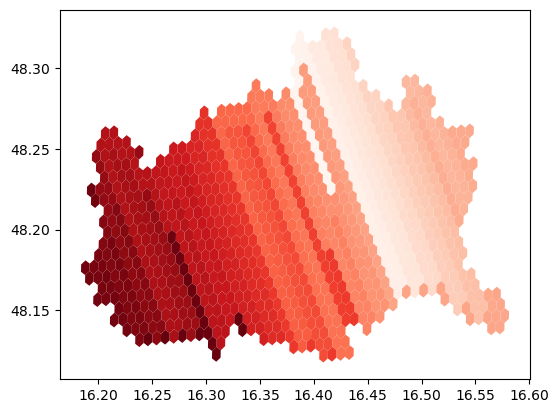

In [29]:
gdf_hex = create_hexagonal_grid(boundary)
gdf_hex = reorder_hexagons_by_proximity(gdf_hex)
display(gdf_hex.head())

# Plot
gdf_hex_plot = gdf_hex.copy()
gdf_hex_plot.to_crs(mercator_proj)
gdf_hex_plot['ord_index'] = gdf_hex_plot.index
gdf_hex_plot.plot(column='ord_index', cmap='Reds')

In [100]:
import requests

api_key = "5b3ce3597851110001cf62482b4bfe101f794dca8be9b961ebbeb9b1"

ex_destination = pois[pois['shop']=='supermarket'].iloc[0].geometry
ex_destination = [[ex_destination.x-1,ex_destination.y]]
print(ex_destination)

ex_source = gdf_hex.iloc[0].geometry.centroid
ex_source = [[ex_source.x,ex_source.y],[ex_source.x,ex_source.y]]
print(ex_source)

# Setup for ORS requests
transport_mode = "driving-car"
ors_url = f"https://api.openrouteservice.org/v2/matrix/{transport_mode}"
headers = {
    'Accept': 'application/json, application/geo+json, application/gpx+xml, img/png; charset=utf-8',
    'Authorization': api_key,
    'Content-Type': 'application/json; charset=utf-8'
}

locations = ex_source+ex_destination

body = {"locations": ex_source+ex_destination,
        "sources": list(range(0,len(ex_source))),
        "destinations": list(range(len(ex_source),len(ex_source+ex_destination))),
        "metrics": ['duration']}

call = requests.post(ors_url, json=body, headers=headers)
print(call.text)

[[15.287667500000001, 48.1969666]]
[[16.449524473992, 48.28211600901065], [16.449524473992, 48.28211600901065]]
{"durations":[[5371.82],[5371.82]],"destinations":[{"location":[15.288266,48.197512],"snapped_distance":75.13}],"sources":[{"location":[16.449553,48.282059],"snapped_distance":6.68},{"location":[16.449553,48.282059],"snapped_distance":6.68}],"metadata":{"attribution":"openrouteservice.org | OpenStreetMap contributors","service":"matrix","timestamp":1741610424113,"query":{"locations":[[16.449524473992,48.28211600901065],[16.449524473992,48.28211600901065],[15.287667500000001,48.1969666]],"profile":"driving-car","profileName":"driving-car","responseType":"json","sources":["0","1"],"destinations":["2"],"metrics":["duration"]},"engine":{"version":"9.0.0","build_date":"2025-01-27T14:56:02Z","graph_date":"2025-01-28T09:38:16Z"}}}


In [ ]:
response = call.json()
durations = response['durations']
destinations = response["destinations"]
destinations = [tuple(d["location"]) for d in destinations]
sources = response["sources"]
sources = [tuple(s["location"]) for s in sources]
print(np.shape(durations),len(sources),len(destinations))
df_results = pd.DataFrame(durations,index=sources,columns=destinations)
for _,row in df_results.iterrows():
    print(row.index[row.argmin()])

(2, 1) 2 1
(15.288266, 48.197512)
(15.288266, 48.197512)


In [ ]:
import pandas as pd
import geopandas as gpd
import requests
import time
from shapely.geometry import Point
from pyproj import Transformer
import numpy as np
from tqdm import tqdm
import requests

api_key = "5b3ce3597851110001cf62482b4bfe101f794dca8be9b961ebbeb9b1"

def download_nearest_pois_travel_times(gdf_hex, pois,
                                         tags={'shop': ['supermarket'], 'leisure': ['park']}, 
                                         transport_mode='foot-walking', 
                                         ors_api_key=api_key,
                                         crs=lon_lat_proj,
                                         areas_crs=equal_area_proj,
                                         rate_limit=40):
    """
    Calculate travel times from each hexagon centroid to the nearest POI of each specified tag type.
    
    Args:
        gdf_hex (GeoDataFrame): Hexagonal grid covering the area of interest
        pois (GeoDataFrame): Points of Interest with multi-index (element_type, osmid)
        tags (dict): Dictionary of tag types and values to analyze (default: {'shop': ['supermarket'], 'leisure': ['park']})
        ors_api_key (str): API key for OpenRouteService
        transport_mode (str): Transport mode for routing (default: 'foot-walking')
        rate_limit (int): Maximum requests per minute to respect API rate limits (default: 40)
        
    Returns:
        GeoDataFrame: Original hexagonal grid with additional columns for travel times to nearest POIs
    """
    # ---------------- SETUP -------------------

    # Save original crs
    original_crs = gdf_hex.crs

    # Define transfomer
    transformer = Transformer.from_crs(equal_area_proj,lon_lat_proj)

    # Create copies of hexagonal grid to store results
    gdf_travel_time = gdf_hex.copy()
    gdf_travel_time = gdf_travel_time.to_crs(crs)
    gdf_nearest_loc = gdf_hex.copy()
    gdf_nearest_loc = gdf_nearest_loc.to_crs(crs)
    
    # Calculate centroids for all hexagons using equal_area_crs
    gdf_centroids = gdf_hex.copy()
    gdf_centroids.to_crs(equal_area_proj)
    centroids = gdf_centroids.geometry.centroid
    centroids = centroids.to_crs(crs)

    # Project also pois to crs
    pois_ = pois.copy()
    pois_ = pois_.to_crs(crs)
    
    # Setup for ORS requests
    ors_url = f"https://api.openrouteservice.org/v2/matrix/{transport_mode}"
    headers = {
        'Accept': 'application/json, application/geo+json, application/gpx+xml, img/png; charset=utf-8',
        'Authorization': ors_api_key,
        'Content-Type': 'application/json; charset=utf-8'
    }
    
    # Filter POIs by each tag type and value, and store in dictionary
    filtered_pois_by_tag = {}
    for tag_key, tag_values in tags.items():
        for tag_value in tag_values:
            tag_name = f"{tag_key}_{tag_value}"
            # Filter POIs that match this tag
            mask = pois_[tag_key] == tag_value
            if mask.any():
                filtered_pois_by_tag[tag_name] = pois_[mask]

    # ---------------- REQUEST DURATIONS -------------------
    
    # ITERATE over filtered pois by tag
    for tag_name, filtered_pois in filtered_pois_by_tag.items():
        # If no POIs match this tag, set travel time to NaN
        if filtered_pois.empty:
            gdf_travel_time[f"timeto_{tag_name}"] = np.nan
            gdf_nearest_loc[f"nearest_{tag_name}"] = np.nan
            continue
            
        # Create columns to store travel times and nearest POIs
        gdf_travel_time[f"timeto_{tag_name}"] = np.nan
        gdf_nearest_loc[f"nearest_{tag_name}"] = np.nan
        
        # Set batch size (max 3500 routes per request are allowed, 500 requests per day)
        batch_size = 10

        # Obtain batches of centroids by spatial clustering
        centroids_batches = KMeans_clustering(centroids)
        
        # ITERATE over hexagons in batches to respect rate limits
        for i in tqdm(range(0, len(centroids), batch_size)):
            batch_centroids = centroids.iloc[i:i+batch_size]

            # Store batch of centroids as origins
            sources = []
            for centroid in batch_centroids:
                sources.append([centroid.x, centroid.y])
                
            # Store relevant POIs as destinations
            destinations = []
            for _, poi in filtered_pois.iterrows():
                if isinstance(poi.geometry, Point):
                    # For Points, use coordinates
                    destinations.append([poi.geometry.x, poi.geometry.y])
                else:
                    # For non-point geometries (ways, relations), use centroid
                    poi_ = poi.copy()
                    poi_.to_crs(areas_crs)
                    centroid = poi_.geometry.centroid
                    centroid = list(transformer.transform(centroid))
                    destinations.append(centroid)

            # Pre-screening based on Euclidean distance

            # Define full list of locations
            locations = sources+destinations

            print(len(destinations))

            # Prepare ORS request body
            body = {"locations": locations,
                "sources": list(range(0,len(sources))),
                "destinations": list(range(len(sources),len(locations))),
                "metrics": ['duration']}
            
            # Make API request
            try:
                call = requests.post(ors_url, json=body, headers=headers)
                results = call.json()
                print(results)
                # Extract relevant data into DataFrame
                res_durations = results["durations"]
                res_sources = [tuple(s["location"]) for s in results["sources"]]
                res_destinations = [tuple(d["location"]) for d in results["destinations"]]
                df_durations = pd.DataFrame(res_durations,index=res_sources,columns=res_destinations)
                
                # For each centroid, find the shortest time to any POI
                for idx, duration_series in df_durations.iterrows():
                    if duration_series:  # If we have any valid durations
                        min_duration = duration_series.min()
                        min_location = duration_series.index(duration_series.argmin())
                        gdf_travel_time.loc[batch_centroids.index[idx], f"timeto_{tag_name}"] = min_duration / 60  # Convert to minutes
                        gdf_nearest_loc.loc[batch_centroids.inedx[idx], f"nearest_{tag_name}"] = min_location
                
                # Respect rate limits
                time.sleep(60 / rate_limit)
                
            except requests.exceptions.RequestException as e:
                print(f"Error with ORS API request for batch starting at index {i}: {e}")
                # Wait longer in case of API issues
                time.sleep(5)

            # Project to desired return_crs
            gdf_travel_time = gdf_travel_time.to_crs(original_crs)
            gdf_nearest_loc = gdf_nearest_loc.to_crs(original_crs)
    
    return gdf_travel_time, gdf_nearest_loc

SyntaxError: invalid syntax (1018040999.py, line 117)

In [125]:
gdf_travel_time, gdf_nearest_loc = download_nearest_pois_travel_times(
    gdf_hex, pois,
    tags = {'shop':['supermarket'], 'leisure':['park']},
    transport_mode='foot-walking'
)

/tmp/ipykernel_6927/3226196869.py:41: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = gdf_hex.geometry.centroid
  0%|          | 0/24 [00:00<?, ?it/s]

{'error': {'code': 6004, 'message': 'Request parameters exceed the server configuration limits. Only a total of 3500 routes are allowed.'}, 'info': {'engine': {'build_date': '2025-01-27T14:56:02Z', 'graph_version': '1', 'version': '9.0.0'}, 'timestamp': 1741616594878}}


KeyError: 'durations'